In [ ]:
!pip install prophet


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import seaborn as sns
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

# List all files in the processed folder
folder_path = "/content/drive/MyDrive/processed"
os.listdir(folder_path)


['part-00003-72f95933-b8ff-4ba4-aade-44b01a906dbb-c000.snappy.parquet',
 '.part-00003-72f95933-b8ff-4ba4-aade-44b01a906dbb-c000.snappy.parquet.crc',
 'part-00000-72f95933-b8ff-4ba4-aade-44b01a906dbb-c000.snappy.parquet',
 '.part-00000-72f95933-b8ff-4ba4-aade-44b01a906dbb-c000.snappy.parquet.crc',
 '.part-00001-72f95933-b8ff-4ba4-aade-44b01a906dbb-c000.snappy.parquet.crc',
 'part-00001-72f95933-b8ff-4ba4-aade-44b01a906dbb-c000.snappy.parquet',
 'part-00002-72f95933-b8ff-4ba4-aade-44b01a906dbb-c000.snappy.parquet',
 '.part-00002-72f95933-b8ff-4ba4-aade-44b01a906dbb-c000.snappy.parquet.crc',
 '._SUCCESS.crc',
 '_SUCCESS']

In [ ]:
# Path to the directory where Parquet files are stored
file_path = '/content/drive/MyDrive/processed/*.parquet'

# Use glob to get all Parquet files in the directory
parquet_files = glob.glob(file_path)

# Read all Parquet files and combine them into a single DataFrame
df = pd.concat([pd.read_parquet(file) for file in parquet_files], ignore_index=True)



In [ ]:
df.columns

Index(['external_code', 'retail', 'id', 'season', 'category', 'color',
       'image_path', 'fabric', 'release_date', 'restock', 'jan_sales',
       'feb_sales', 'mar_sales', 'apr_sales', 'may_sales', 'jun_sales',
       'jul_sales', 'aug_sales', 'sep_sales', 'oct_sales', 'nov_sales',
       'dec_sales', 'price'],
      dtype='object')

In [ ]:
# Convert 'release_date' to datetime
df['release_date'] = pd.to_datetime(df['release_date'])

# Set 'release_date' as the index
df.set_index('release_date', inplace=True)

df.head()

,external_code,retail,id,season,category,color,image_path,fabric,restock,jan_sales,...,apr_sales,may_sales,jun_sales,jul_sales,aug_sales,sep_sales,oct_sales,nov_sales,dec_sales,price
release_date,,,,,,,,,,,,,,,,,,,,,
2019-11-18,5492,1,102899,AW19,solid color top,black,AI19/05492.png,tulle,8,3.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.065850
2019-11-18,5492,1,102899,AW19,solid color top,black,AI19/05492.png,tulle,8,3.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.065850
2019-11-18,5492,1,102899,AW19,solid color top,black,AI19/05492.png,tulle,8,3.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.052658
2019-11-18,5492,1,102899,AW19,solid color top,black,AI19/05492.png,tulle,8,3.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.065850
2019-11-18,5492,1,102899,AW19,solid color top,black,AI19/05492.png,tulle,8,3.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.065850


Read Parquet files

In [ ]:
df.describe()


,external_code,retail,id,restock,jan_sales,feb_sales,mar_sales,apr_sales,may_sales,jun_sales,jul_sales,aug_sales,sep_sales,oct_sales,nov_sales,dec_sales,price
count,3.946900e+06,3.946900e+06,3.946900e+06,3.946900e+06,3.946900e+06,3.946900e+06,3.946900e+06,3.946900e+06,3.946900e+06,3.946900e+06,3.946900e+06,3.946900e+06,3.946900e+06,3.946900e+06,3.946900e+06,3.946900e+06,3.946900e+06
mean,3.360238e+03,4.342241e+01,5.774789e+04,2.717624e+01,1.933457e+00,1.631225e+00,1.612558e+00,1.667093e+00,1.670425e+00,1.714125e+00,1.673734e+00,1.521412e+00,1.354307e+00,1.191253e+00,1.043044e+00,8.994973e-01,8.257010e-02
std,1.562971e+03,2.895981e+01,3.022815e+04,2.099087e+01,1.350501e+00,1.689338e+00,1.748555e+00,1.862998e+00,1.932213e+00,2.072543e+00,2.127450e+00,2.034582e+00,1.957420e+00,1.921213e+00,1.958592e+00,1.829939e+00,3.717594e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.000000e+00,-3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.000000e+00,-2.000000e+00,0.000000e+00,1.097125e-02
25%,2.136000e+03,1.900000e+01,3.343700e+04,1.500000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.494421e-02
50%,3.487000e+03,4.000000e+01,5.997600e+04,2.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,7.693069e-02
75%,4.850000e+03,6.500000e+01,8.309400e+04,3.200000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,8.792393e-02
max,5.577000e+03,1.250000e+02,1.068490e+05,3.890000e+02,2.500000e+01,2.700000e+01,2.700000e+01,2.700000e+01,4.300000e+01,3.400000e+01,4.900000e+01,3.600000e+01,5.000000e+01,4.500000e+01,5.300000e+01,4.300000e+01,5.714286e-01


visualization

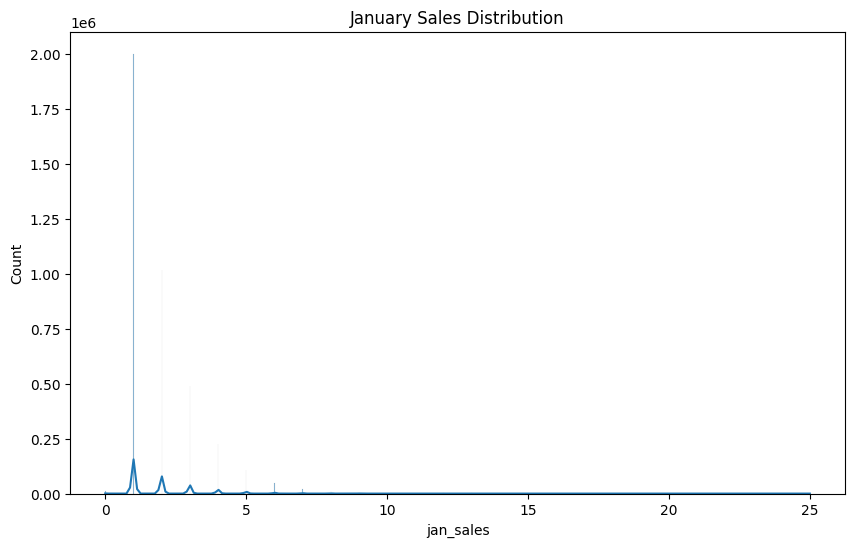

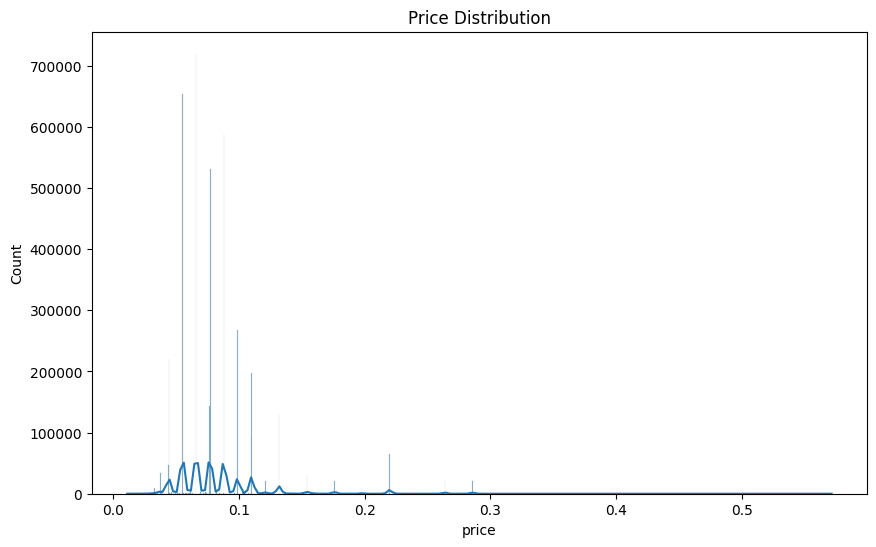

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram for sales
plt.figure(figsize=(10, 6))
sns.histplot(df['jan_sales'], kde=True)
plt.title('January Sales Distribution')
plt.show()

# Plot histogram for price
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True)
plt.title('Price Distribution')
plt.show()


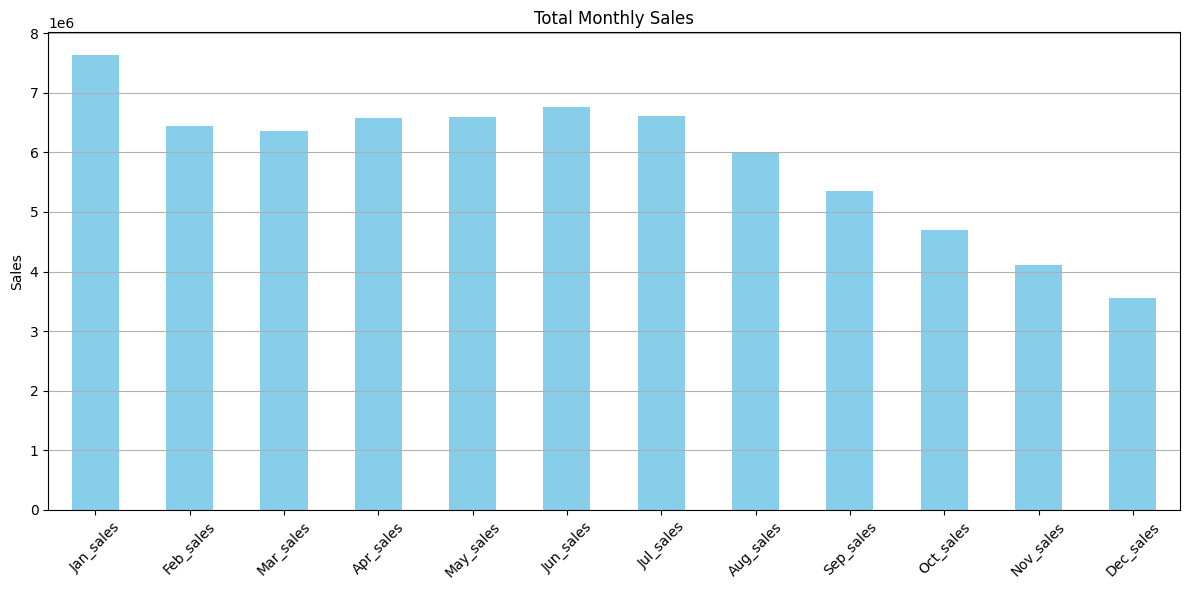

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


monthly_columns = ['jan_sales', 'feb_sales', 'mar_sales', 'apr_sales', 'may_sales',
                   'jun_sales', 'jul_sales', 'aug_sales', 'sep_sales', 'oct_sales',
                   'nov_sales', 'dec_sales']

monthly_sales = df[monthly_columns].sum()
monthly_sales.index = [month.capitalize() for month in monthly_columns]  # Capitalize for better display

plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='bar', color='skyblue')
plt.title('Total Monthly Sales')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


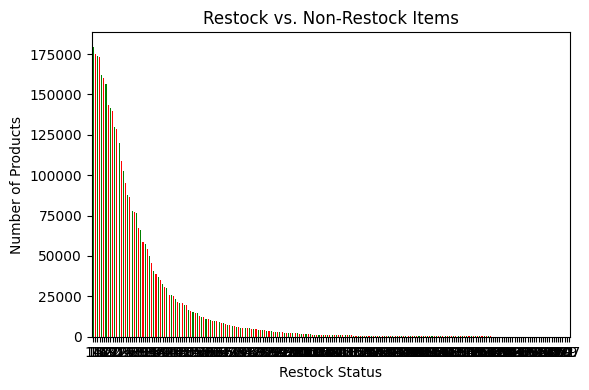

In [ ]:
df['restock'] = df['restock'].astype(str).str.lower()  # standardize
restock_counts = df['restock'].value_counts()

restock_counts.plot(kind='bar', color=['green', 'red'], figsize=(6, 4))
plt.title('Restock vs. Non-Restock Items')
plt.xlabel('Restock Status')
plt.ylabel('Number of Products')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

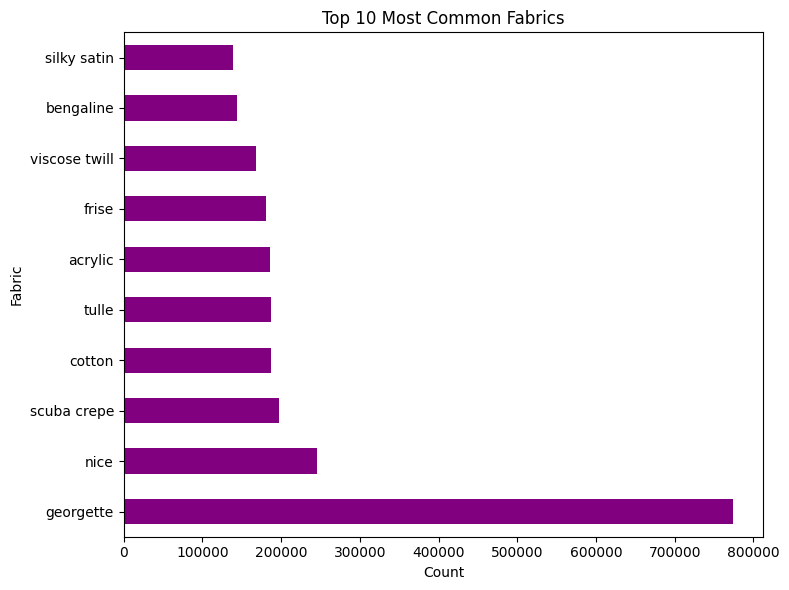

In [ ]:
fabric_counts = df['fabric'].value_counts().nlargest(10)

fabric_counts.plot(kind='barh', color='purple', figsize=(8, 6))
plt.title('Top 10 Most Common Fabrics')
plt.xlabel('Count')
plt.ylabel('Fabric')
plt.tight_layout()
plt.show()


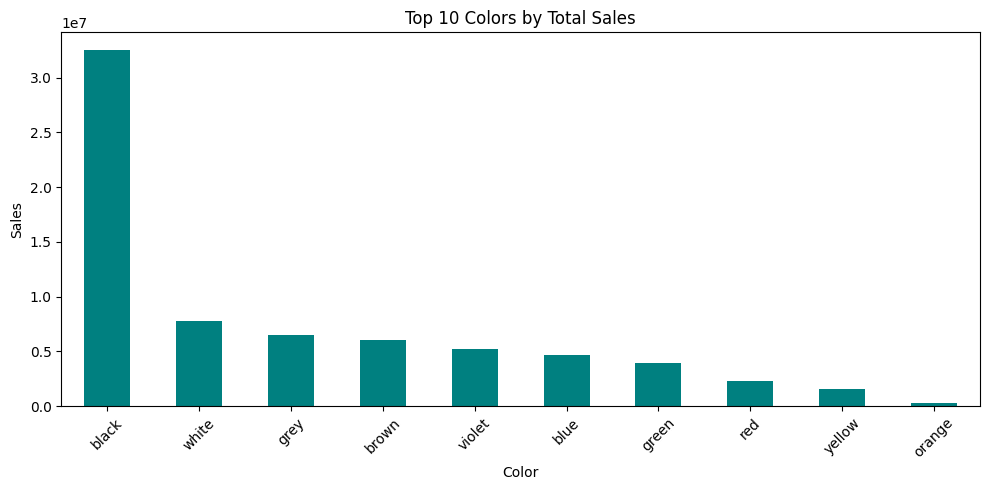

In [ ]:
color_sales = df.groupby('color')[monthly_columns].sum().sum(axis=1)
color_sales.nlargest(10).plot(kind='bar', figsize=(10, 5), color='teal')
plt.title('Top 10 Colors by Total Sales')
plt.xlabel('Color')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


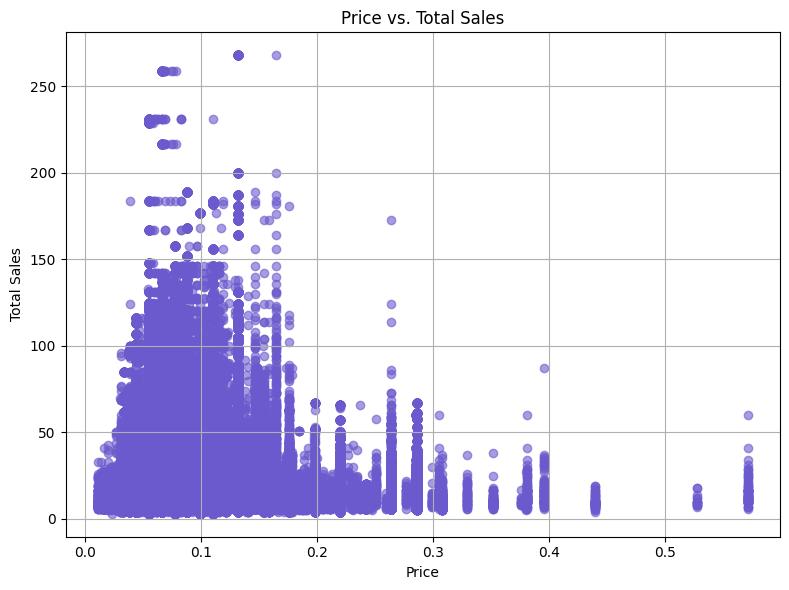

In [ ]:
df['total_sales'] = df[monthly_columns].sum(axis=1)

plt.figure(figsize=(8, 6))
plt.scatter(df['price'], df['total_sales'], alpha=0.6, color='slateblue')
plt.title('Price vs. Total Sales')
plt.xlabel('Price')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()


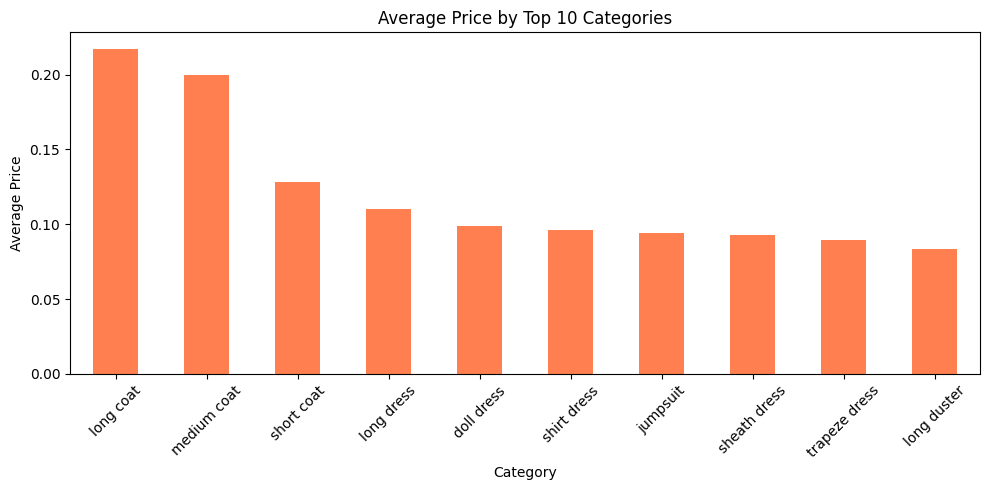

In [ ]:
category_avg_price = df.groupby('category')['price'].mean().sort_values(ascending=False).head(10)

category_avg_price.plot(kind='bar', figsize=(10, 5), color='coral')
plt.title('Average Price by Top 10 Categories')
plt.xlabel('Category')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Feature Engineering

In [ ]:
# Check column names
print(df.columns)


Index(['external_code', 'retail', 'id', 'season', 'category', 'color',
       'image_path', 'fabric', 'restock', 'jan_sales', 'feb_sales',
       'mar_sales', 'apr_sales', 'may_sales', 'jun_sales', 'jul_sales',
       'aug_sales', 'sep_sales', 'oct_sales', 'nov_sales', 'dec_sales',
       'price', 'total_sales'],
      dtype='object')


In [ ]:

season_sales = df.groupby('season')[['jan_sales', 'feb_sales', 'mar_sales', 'apr_sales', 'may_sales', 'jun_sales',
                                    'jul_sales', 'aug_sales', 'sep_sales', 'oct_sales', 'nov_sales', 'dec_sales']].sum()

season_sales['total_sales'] = season_sales.sum(axis=1)

# Display the aggregated data
print(season_sales)


        jan_sales  feb_sales  mar_sales  apr_sales  may_sales  jun_sales  \
season                                                                     
AW17     959380.0   859964.0   837449.0   842592.0   851724.0   821124.0   
AW18    1214380.0  1054858.0   991781.0  1063312.0  1057048.0  1025393.0   
AW19    1922508.0  1573238.0  1647766.0  1688839.0  1606615.0  1661315.0   
SS17     686534.0   558496.0   581781.0   583053.0   653488.0   769674.0   
SS18    1170529.0   964375.0   909502.0   942197.0   981293.0  1006607.0   
SS19    1677829.0  1427351.0  1396328.0  1459856.0  1442832.0  1481368.0   

        jul_sales  aug_sales  sep_sales  oct_sales  nov_sales  dec_sales  \
season                                                                     
AW17     774690.0   705840.0   644932.0   526532.0   466876.0   388498.0   
AW18     935861.0   880393.0   802981.0   693852.0   601419.0   506230.0   
AW19    1548367.0  1317482.0  1105528.0   979929.0   795009.0   697665.0   
SS17     81

In [ ]:
import pandas as pd
# Converting season to a time series index by assuming 'AW' is fall/winter and 'SS' is spring/summer
# Create a mapping
season_year_map = {'AW17': '2017', 'AW18': '2018', 'AW19': '2019',
                   'SS17': '2017', 'SS18': '2018', 'SS19': '2019'}
season_sales['year'] = season_sales.index.map(season_year_map)

# Convert to a time series format
season_sales['year'] = pd.to_datetime(season_sales['year'])
season_sales.set_index('year', inplace=True)
print(season_sales)





            jan_sales  feb_sales  mar_sales  apr_sales  may_sales  jun_sales  \
year                                                                           
2017-01-01   959380.0   859964.0   837449.0   842592.0   851724.0   821124.0   
2018-01-01  1214380.0  1054858.0   991781.0  1063312.0  1057048.0  1025393.0   
2019-01-01  1922508.0  1573238.0  1647766.0  1688839.0  1606615.0  1661315.0   
2017-01-01   686534.0   558496.0   581781.0   583053.0   653488.0   769674.0   
2018-01-01  1170529.0   964375.0   909502.0   942197.0   981293.0  1006607.0   
2019-01-01  1677829.0  1427351.0  1396328.0  1459856.0  1442832.0  1481368.0   

            jul_sales  aug_sales  sep_sales  oct_sales  nov_sales  dec_sales  \
year                                                                           
2017-01-01   774690.0   705840.0   644932.0   526532.0   466876.0   388498.0   
2018-01-01   935861.0   880393.0   802981.0   693852.0   601419.0   506230.0   
2019-01-01  1548367.0  1317482.0  11055

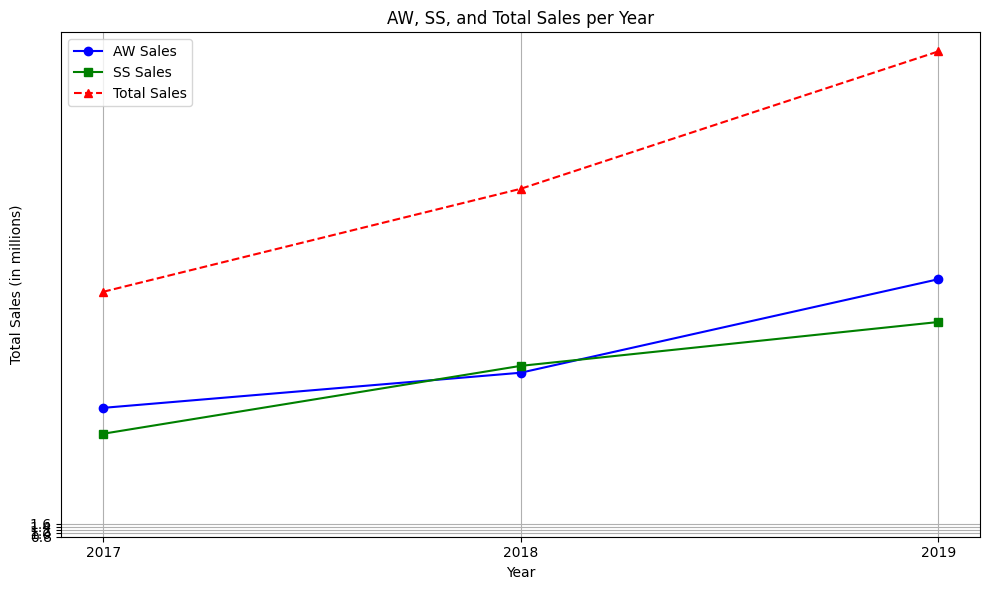

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


season_sales = season_sales.copy()
season_sales['season_type'] = season_sales.index.astype(str).str.extract(r'([A-Z]+)', expand=False)
season_sales['year'] = season_sales.index.astype(str).str.extract(r'(\d+)', expand=False)
season_sales['year'] = '20' + season_sales['year']  # e.g., '17' → '2017'


grouped = season_sales.groupby(['year', 'season_type'])['total_sales'].sum().unstack(fill_value=0)
grouped['Total'] = grouped.sum(axis=1)


grouped_millions = grouped / 1e6


plt.figure(figsize=(10, 6))

if 'AW' in grouped_millions.columns:
    plt.plot(grouped_millions.index, grouped_millions['AW'], label='AW Sales', color='blue', marker='o')

if 'SS' in grouped_millions.columns:
    plt.plot(grouped_millions.index, grouped_millions['SS'], label='SS Sales', color='green', marker='s')

plt.plot(grouped_millions.index, grouped_millions['Total'], label='Total Sales', color='red', linestyle='--', marker='^')


plt.yticks(np.arange(0.8, 1.8, 0.2))


plt.xlabel('Year')
plt.ylabel('Total Sales (in millions)')
plt.title('AW, SS, and Total Sales per Year')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



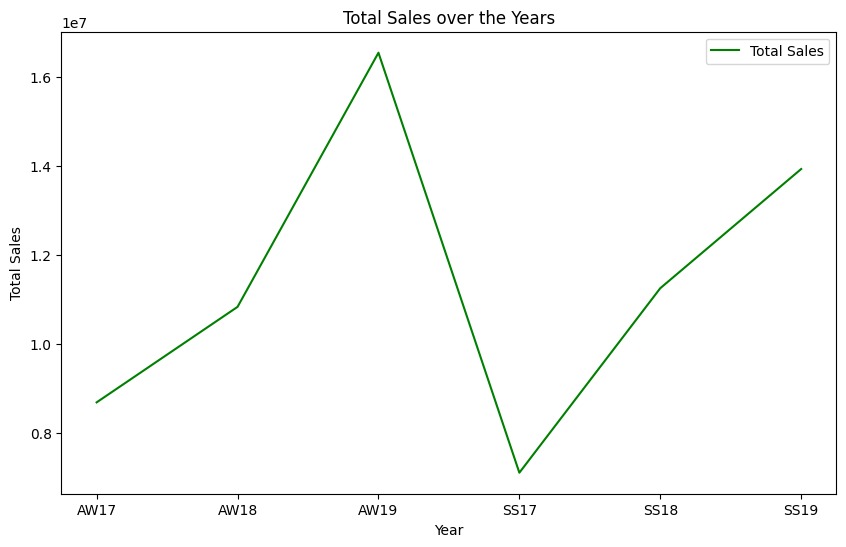

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt


try:

    ts_data = season_sales['total_sales']

    plt.figure(figsize=(10, 6))


    plt.plot(ts_data, label='Total Sales', color='green') # Changed color

    plt.xlabel('Year')
    plt.ylabel('Total Sales')
    plt.title('Total Sales over the Years')
    plt.legend()
    plt.show()

except KeyError:
    print("Error: 'total_sales' column not found in season_sales DataFrame.")
except Exception as e:
    print(f"An error occurred: {e}")

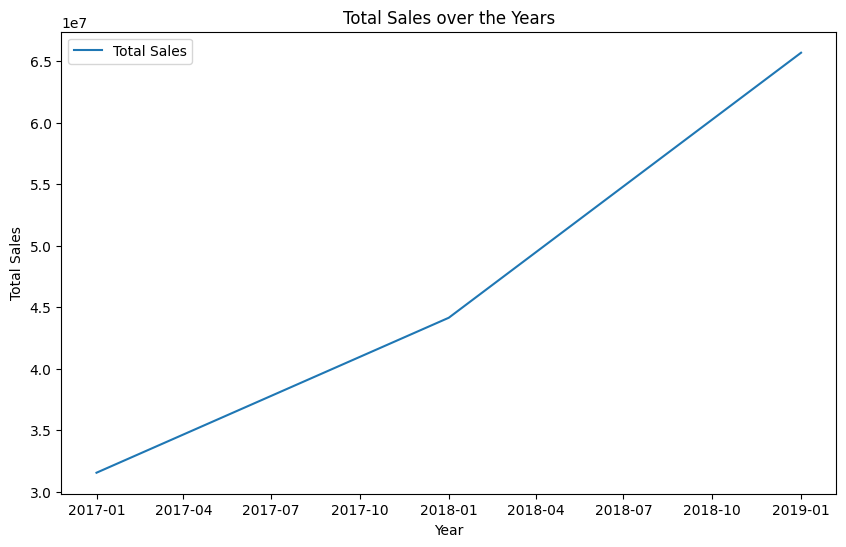

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarni

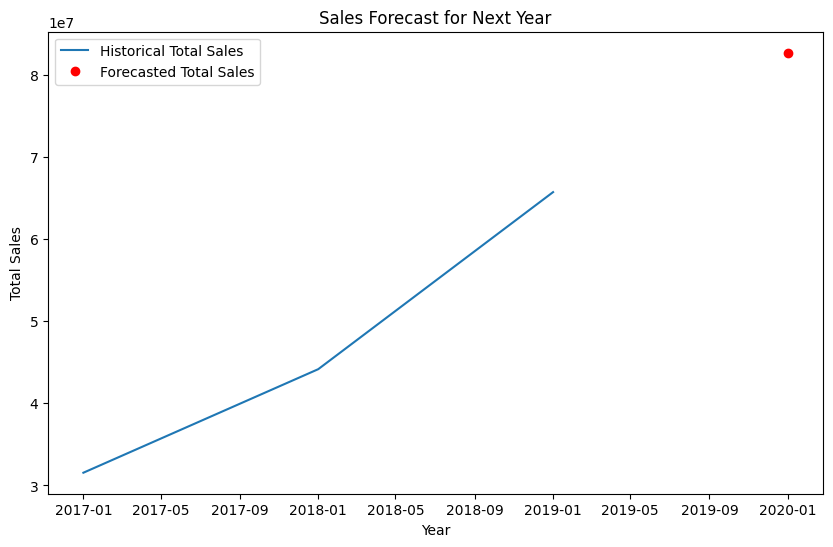

Forecasted total sales for the next year: 82650919.91024567


<ipython-input-69-1c16a05d17e8>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Forecasted total sales for the next year: {forecast[0]}")


In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Extract total sales for ARIMA modeling
ts_data = annual_sales['total_sales']

# Plot the total sales to visualize any patterns or trends
plt.figure(figsize=(10, 6))
plt.plot(ts_data, label='Total Sales')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Total Sales over the Years')
plt.legend()
plt.show()

# Fit the ARIMA model (start with ARIMA(1, 1, 1))
model = sm.tsa.ARIMA(ts_data, order=(1, 1, 1))
model_fit = model.fit()

# Forecasting for the next year
forecast = model_fit.forecast(steps=1)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(ts_data, label='Historical Total Sales')
plt.plot([ts_data.index[-1] + pd.DateOffset(years=1)], forecast, 'ro', label='Forecasted Total Sales')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Sales Forecast for Next Year')
plt.legend()
plt.show()

# Print the forecasted sales
print(f"Forecasted total sales for the next year: {forecast[0]}")

